In [70]:
import numpy as np
from sklearn.decomposition import PCA
import scipy
import scipy.io as sio
import os
import pandas as pd
import math
import matplotlib.pyplot as plt
from collections import namedtuple
from os.path import dirname, join as pjoin

import sys
sys.path.append(r'C:\Users\root\Documents\00phd\00Code\ForSignalProcessing\spaudiopy\spaudiopy') 
from plot import spectrum, transfer_function

In [43]:
HRTFdata = namedtuple('HRTF',['sid','HRIR_L','HRIR_R','HRTF_L','HRTF_R','ITD','DTF_L','DTF_R','DTF2_L','DTF2_R'])
HRTFdata_full=[]

# Define parameters
fs = 44100
Nbases = [1,5,10,20,30,50,75,100,128]   # number of bases to be selected from
N = 256; # FFT length

# load data
names=os.listdir('C:/Users/root/Documents/00phd/00ThirdPartyCode/ForSignalProcessing/SOFA API/SOFA API for Matlab and Octave 1.1.1/HRTFs/CIPIC_hrtf_database/standard_hrir_database/')
# print(names)
# column_names=['id','elevation','azimuth','hrtf']
# input=pd.DataFrame(columns=column_names)
# input.id=names[1:]
# print(input)

for i in range(1, len(names)-1):  # You can replace 3 with the number of subjects you have
    data_dir = pjoin('C:/Users/root/Documents/00phd/00ThirdPartyCode/ForSignalProcessing/SOFA API/SOFA API for Matlab and Octave 1.1.1/HRTFs/CIPIC_hrtf_database/standard_hrir_database/', names[i])
    mat_fname = pjoin(data_dir, 'hrir_final.mat')
    data=sio.loadmat(mat_fname)
    sid = names[i]
    HRIR_L=data.get('hrir_l')
    HRIR_R=data.get('hrir_r')
    HRTF_L=scipy.fft.rfft(HRIR_L,N,axis=-1)
    HRTF_R=scipy.fft.rfft(HRIR_R,N,axis=-1)
    ITD=data.get('ITD')
    DTF_L=np.zeros(HRTF_L.shape)
    DTF_R=np.zeros(HRTF_L.shape)
    DTF2_L=np.zeros(HRTF_L.shape)
    DTF2_R=np.zeros(HRTF_L.shape)

    # Append data as to the list
    HRTFdata_full.append(HRTFdata(sid,HRIR_L,HRIR_R,HRTF_L,HRTF_R,ITD,DTF_L,DTF_R,DTF2_L,DTF2_R))

(25, 50, 129)


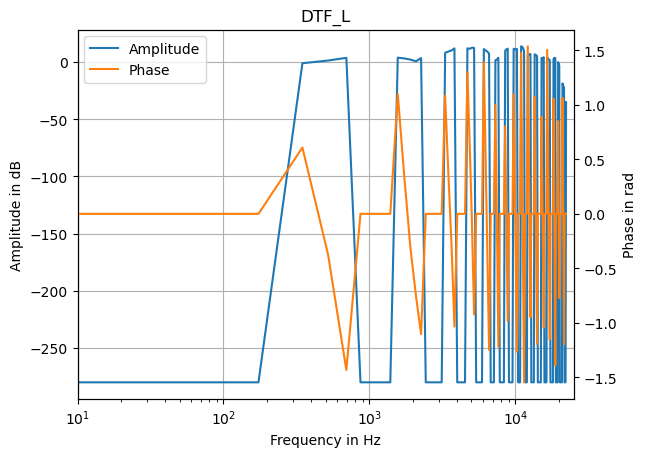

In [73]:
# print(HRIR_L[1,1,:])
xx=scipy.fft.rfft(HRIR_L[1,1,:],N)
yy=scipy.fft.irfft(xx,N)
# print(yy)

print(HRTFdata_full[4].DTF_L.shape)
freq=np.linspace(0, math.ceil(N/2)+1, math.ceil(N/2)+1)*fs/N
transfer_function(freq, xx, title='DTF_L')

# plt.semilogx(freq,20*np.log10(np.abs(xx)))

c:\Users\root\miniconda3\envs\yuqing23\Lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


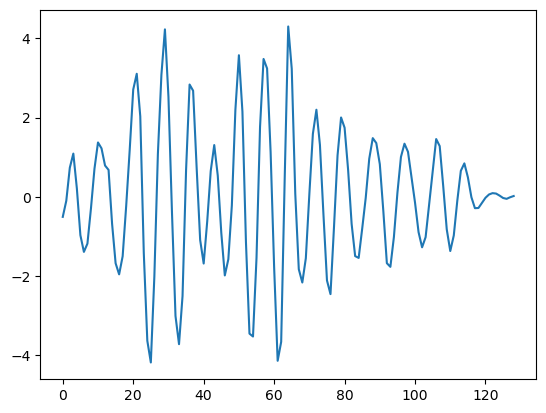

In [48]:
plt.plot(xx)

In [6]:
print(len(HRTFdata_full))

44


In [7]:
meanHRTF_L=np.zeros((len(HRTFdata_full),HRTFdata_full[0].HRTF_L.shape[2]))
meanHRTF_R=np.zeros((len(HRTFdata_full),HRTFdata_full[0].HRTF_L.shape[2]))

# Compute DTF and DTF2
for i in range(0, len(HRTFdata_full)): # for each subject
    for j in range(0, HRTFdata_full[0].DTF_L.shape[2]): # for each fft bin
        sum_L = np.sum(HRTFdata_full[i].HRTF_L.take(indices=j,axis=2), axis=(0,1)) # unweighted by IID
        sum_R = np.sum(HRTFdata_full[i].HRTF_R.take(indices=j,axis=2), axis=(0,1))

        meanHRTF_L[i][j] = sum_L / (HRTFdata_full[0].HRTF_L.shape[0]*HRTFdata_full[0].HRTF_L.shape[1])
        meanHRTF_R[i][j] = sum_R / (HRTFdata_full[0].HRTF_L.shape[0]*HRTFdata_full[0].HRTF_L.shape[1])
        
        HRTFdata_full[i].DTF_L[:,:,j] = np.divide(HRTFdata_full[i].HRTF_L[:,:,j], meanHRTF_L[i][j])    # element-wise division
        HRTFdata_full[i].DTF_R[:,:,j] = np.divide(HRTFdata_full[i].HRTF_R[:,:,j], meanHRTF_R[i][j])
        
#    subj.meanHRTF(i) = (subj.meanHRTF_l(i)+subj.meanHRTF_r(i)) / 2; # in case u need it


C:\Users\root\AppData\Local\Temp\ipykernel_32392\2862158546.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  meanHRTF_L[i][j] = sum_L / (HRTFdata_full[0].HRTF_L.shape[0]*HRTFdata_full[0].HRTF_L.shape[1])
C:\Users\root\AppData\Local\Temp\ipykernel_32392\2862158546.py:11: ComplexWarning: Casting complex values to real discards the imaginary part
  meanHRTF_R[i][j] = sum_R / (HRTFdata_full[0].HRTF_L.shape[0]*HRTFdata_full[0].HRTF_L.shape[1])
C:\Users\root\AppData\Local\Temp\ipykernel_32392\2862158546.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  HRTFdata_full[i].DTF_L[:,:,j] = np.divide(HRTFdata_full[i].HRTF_L[:,:,j], meanHRTF_L[i][j])    # element-wise division
C:\Users\root\AppData\Local\Temp\ipykernel_32392\2862158546.py:14: ComplexWarning: Casting complex values to real discards the imaginary part
  HRTFdata_full[i].DTF_R[:,:,j] = np.divide(HRTFdata_full[i].HRTF_R[:,:,j], meanHRTF_R[i][j])


In [35]:
print(len(HRTFdata_full))

44
[-5.72922139e-01+0.j         -3.54964062e-02+0.45586976j
  5.27215034e-01+0.60087193j  1.07913211e+00-0.35790518j
  2.80434868e-01-1.24915903j -6.69632457e-01-0.95493131j
 -1.23311678e+00-0.3798767j  -1.08967827e+00+0.68194412j
 -4.54716213e-01+1.02093211j  2.04115418e-01+1.07909651j
  7.02031623e-01+0.94870749j  1.27163468e+00+0.23274368j
  1.07312567e+00-0.27399858j  1.13585223e+00-0.98722913j
  3.42063949e-01-1.72274381j -9.67633981e-01-1.91569328j
 -2.16036747e+00-0.81974466j -2.42539929e+00+0.78585236j
 -1.33523502e+00+2.1242154j  -7.72331342e-03+2.78384259j
  2.03496882e+00+2.59248632j  3.62531632e+00+0.47146616j
  3.52041544e+00-2.08685163j  5.98194747e-01-4.56584584j
 -2.36424135e+00-3.36549403j -4.39206406e+00-0.95756565j
 -3.34703588e+00+2.37176747j -1.04528836e+00+3.68750153j
  1.37243232e+00+3.24749638j  3.37410774e+00+2.02522403j
  3.76457606e+00-1.09390308j  2.08539726e+00-3.44207673j
 -1.14426297e+00-3.50987809j -3.00541007e+00-1.55519037j
 -2.53127560e+00+0.82977066j

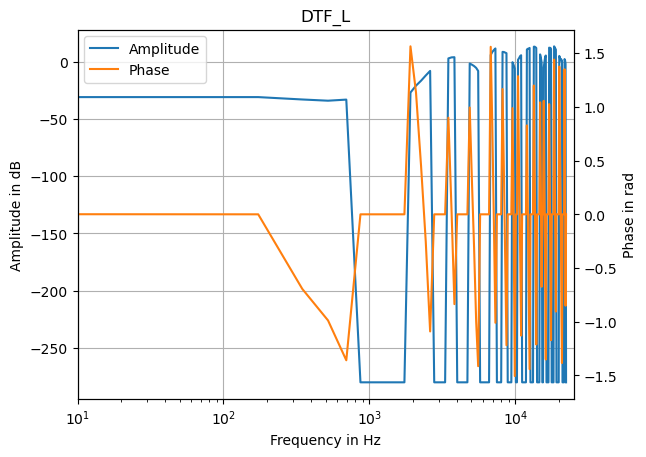

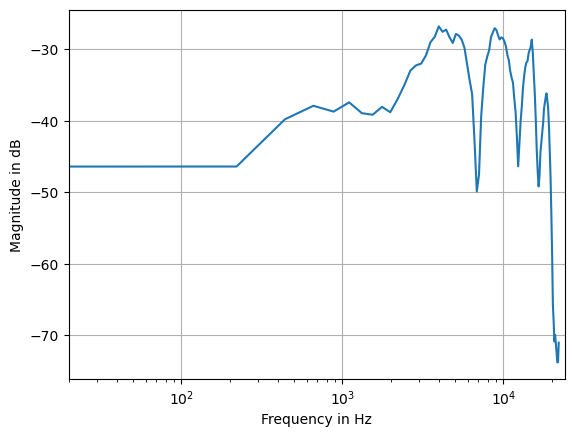

In [37]:
# Plot
freq=np.linspace(0, math.ceil(N/2)+1, math.ceil(N/2)+1)*fs/N
transfer_function(freq, HRTFdata_full[0].HRTF_L[1,1,:], title='DTF_L')
spectrum(HRTFdata_full[0].HRIR_L[1,1,:], fs)